<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Position-space" data-toc-modified-id="Position-space-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Position space</a></span><ul class="toc-item"><li><span><a href="#Translation-of-COM-instead-of-rotation-around-origin" data-toc-modified-id="Translation-of-COM-instead-of-rotation-around-origin-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Translation of COM instead of rotation around origin</a></span></li><li><span><a href="#Determine-position-index" data-toc-modified-id="Determine-position-index-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Determine position index</a></span></li></ul></li><li><span><a href="#Orientation-space" data-toc-modified-id="Orientation-space-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Orientation space</a></span><ul class="toc-item"><li><span><a href="#Determine-internal-coordinate-system-(principal-axes)" data-toc-modified-id="Determine-internal-coordinate-system-(principal-axes)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Determine internal coordinate system (principal axes)</a></span></li><li><span><a href="#Realize-that-determining-principal-axes-isn't-sufficient" data-toc-modified-id="Realize-that-determining-principal-axes-isn't-sufficient-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Realize that determining principal axes isn't sufficient</a></span></li><li><span><a href="#Determine-quaternion-index" data-toc-modified-id="Determine-quaternion-index-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Determine quaternion index</a></span></li></ul></li><li><span><a href="#Full-conversion-3N-coordinates-<->-7D-gridpoint" data-toc-modified-id="Full-conversion-3N-coordinates-<->-7D-gridpoint-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Full conversion 3N coordinates &lt;-&gt; 7D gridpoint</a></span></li><li><span><a href="#MSM" data-toc-modified-id="MSM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MSM</a></span></li></ul></div>

In [1]:
import sys
import os

try:
    os.chdir(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup/molgri")
    sys.path.append(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup")
except FileNotFoundError:
    os.chdir(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    sys.path.append(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray
import MDAnalysis as mda
from scipy.spatial.distance import cdist
from scipy.spatial.transform import Rotation
from MDAnalysis.analysis.base import AnalysisFromFunction
import seaborn as sns

from molgri.plotting.widgets import ViewManager
from molgri.paths import PATH_OUTPUT_PT, PATH_INPUT_BASEGRO
from molgri.space.fullgrid import FullGrid
from molgri.space.utils import normalise_vectors, k_argmax_in_array, distance_between_quaternions, q_in_upper_sphere
from molgri.molecules.transitions import MSM, SimulationHistogram
from molgri.plotting.transition_plots import TransitionPlot
from molgri.space.translations import get_between_radii

sns.set_context("notebook")

## Position space

In a PT, the order is as following:
- position 1, orientation 1,
- position 1, orientation 2,
- ...
- position 1, orientation $N_b$,
- position 2, orientation 1,
- position 2, orientation 2,
- ...
- ...
- position $N_p$, orientation $N_b$


### Translation of COM instead of rotation around origin

See: every $N_b$-th frame of PT has the exact same orientation.

In [3]:
# generated a file with
# python -m molgri.scripts.generate_pt -m1 H2O -m2 H2O -o "12" -b "8" -t "linspace(0.2, 1, 5)" --recal
pt_name = "H2O_H2O_0528"
pt_universe = mda.Universe(f"{PATH_OUTPUT_PT}{pt_name}.gro",
                           f"{PATH_OUTPUT_PT}{pt_name}.trr")
len_pt = len(pt_universe.trajectory)

vm = ViewManager(pt_universe)
# plot every 8th frame
# because we have 8 orientations, every 8th structure should be translated version of each other
every_eighth_0 = np.arange(0, len_pt, 8)
print(list(every_eighth_0))
vm.plot_frames_overlapping(every_eighth_0[20:30])

[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472]


NGLWidget()

In [4]:
vm.fresh_view()
every_eighth_3 = np.arange(3, len_pt, 8)
# similar thing for another class of identical orientations
print(list(every_eighth_3))
vm.plot_frames_overlapping(every_eighth_3[20:30])

[3, 11, 19, 27, 35, 43, 51, 59, 67, 75, 83, 91, 99, 107, 115, 123, 131, 139, 147, 155, 163, 171, 179, 187, 195, 203, 211, 219, 227, 235, 243, 251, 259, 267, 275, 283, 291, 299, 307, 315, 323, 331, 339, 347, 355, 363, 371, 379, 387, 395, 403, 411, 419, 427, 435, 443, 451, 459, 467, 475]


NGLWidget()

### Determine position index

- radial index: calculate the norm of COM for each frame, assign to the closest radius (Euclidean distance)
- direction (o_grid) index: normalise the COM for each frame, assign to the closest point on unit sphere (cosinus distance)
- position index: radial_index * num_directions + direction_index

In [5]:
# separately determine index in the radial direction and on the sphere, then combine

def assign_2_t_grid(my_trajectory: mda.Universe, t_grid_points: NDArray,
                         second_molecule: str) -> NDArray:
    """
    Given a trajectoryand an array of available radial (t-grid) points, assign each frame of the trajectory
    to the closest radial point.
    
    Args:
        my_trajectory: a Universe of two molecules
        radial_grid_points: a sorted array of available radial grid distances in A like [2, 4, 6]
        second_molecule: a string that tdefines which part of the Universe is a moving molecule
    
    Returns:
        an integer array as long as the trajectory, each element an index of the closest point of the radial grid
        like [0, 0, 0, 1, 1, 1, 2 ...] (for a PT with 3 orientations)
    """
    t_selection = AnalysisFromFunction(lambda ag: np.argmin(np.abs(t_grid_points-np.linalg.norm(ag.center_of_mass())), axis=0),
                                     my_trajectory.trajectory,
                                     my_trajectory.select_atoms(second_molecule))
    t_selection.run()
    t_indices = t_selection.results['timeseries'].flatten()
    return t_indices

def assign_2_o_grid(my_trajectory: mda.Universe, o_grid_points: NDArray, 
                           second_molecule: str) -> NDArray:
    """
    Assign every frame of the trajectory (or PT) to the best fitting point of position grid

    Returns:
        an array of position grid indices
    """
    # now using a normalized com and a metric on a sphere, determine which of o_grid_points is closest
    o_selection = AnalysisFromFunction(lambda ag: np.argmin(cdist(o_grid_points, normalise_vectors(
        ag.center_of_mass())[np.newaxis, :], metric="cos"), axis=0),
                                     my_trajectory.trajectory,
                                     my_trajectory.select_atoms(second_molecule))
    o_selection.run()
    o_indices = o_selection.results['timeseries'].flatten()
    return o_indices

def assign_2_position_grid(my_trajectory: mda.Universe, o_grid_points: NDArray, t_grid_points: NDArray,
                         second_molecule: str):
    """
    Combine assigning to t_grid and o_grid.
    """
    t_assignments = assign_2_t_grid(my_trajectory=my_trajectory, t_grid_points=t_grid_points, 
                                    second_molecule=second_molecule)
    o_assignments = assign_2_o_grid(my_trajectory=my_trajectory, o_grid_points=o_grid_points,
                                   second_molecule=second_molecule)
    # sum up the layer index and o index correctly
    return np.array(t_assignments * len(o_grid_points) + o_assignments, dtype=int)


In [5]:
# test with a PT
sh_water_small = SimulationHistogram("H2O_H2O_0528", "H2O", is_pt=True, second_molecule_selection="bynum 4:6",
                                    use_saved=False)
position_assignments_ws = sh_water_small.get_position_assignments()

print(position_assignments_ws)
# test: a PT should have the first 8 elements in position 0, then 8 in position 1 ...
expected_assignments = np.repeat(np.arange(12*5), 8)
assert np.all(position_assignments_ws == expected_assignments)

[ 0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14
 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17
 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20
 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26
 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29
 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32
 33 33 33 33 33 33 33 33 34 34 34 34 34 34 34 34 35 35 35 35 35 35 35 35
 36 36 36 36 36 36 36 36 37 37 37 37 37 37 37 37 38 38 38 38 38 38 38 38
 39 39 39 39 39 39 39 39 40 40 40 40 40 40 40 40 41

In [7]:
# test with a real trajectory: see how long it takes
traj_full_grid = FullGrid(b_grid_name="20", o_grid_name="25", t_grid_name="linspace(0.2, 0.9, 20)")
sh_water_traj = SimulationHistogram("H2O_H2O_0095_30000", "H2O", is_pt=False, full_grid=traj_full_grid,
                                    second_molecule_selection="bynum 4:6", use_saved=False)
position_assignments_wt = sh_water_traj.get_position_assignments()

print(f"Assigning 25000 frames to 25x20={25*20} positions")

Assigning 25000 frames to 25x20=500 positions


Most popular assignments are [57 77 52 63 82 88 93 78 68 53] with population [ 912  920  995  933  929  926 1253 1286 2218 1730]


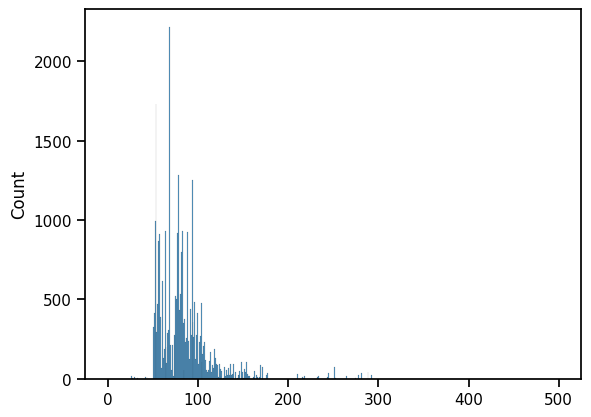

In [10]:
# make a histogram of most populated positions
sns.histplot(position_assignments_wt, stat="count", bins=np.arange(501))

popular, counts = np.unique(position_assignments_wt, return_counts=True)
max_counts = k_argmax_in_array(counts, 10)
print(f"Most popular assignments are {popular[max_counts]} with population {counts[max_counts]}")
plt.show()

In [14]:
# plot some frames of a real trajectory that belong to the same position grid point
vm = ViewManager(sh_water_traj.trajectory_universe)
# plot a selection (because too many) that are all assigned to grid point 26
assigned_to_26 = np.where(position_assignments_wt == 68)[0]
# show in VMD for a better view
print(list(np.random.choice(assigned_to_26, 100)))
vm.plot_frames_overlapping(np.random.choice(assigned_to_26, 30))

[7247, 20312, 22097, 29234, 24064, 5486, 27533, 27093, 26617, 19727, 3463, 28391, 28136, 20718, 21714, 26605, 5467, 28557, 26426, 3481, 24139, 24515, 5178, 21701, 19766, 6078, 3104, 7346, 27041, 5180, 15577, 657, 647, 21686, 27529, 18770, 26610, 29234, 20015, 20030, 5182, 28120, 22065, 19949, 18870, 20063, 6045, 28369, 6067, 20168, 25889, 28561, 19560, 3108, 20075, 28571, 10288, 22102, 27538, 28327, 5523, 7250, 20191, 18762, 28562, 27993, 5300, 17710, 3100, 19551, 15798, 5374, 26560, 5385, 5392, 19733, 5873, 6067, 2834, 13505, 8100, 19056, 7303, 18779, 28154, 25682, 5510, 21814, 27710, 3213, 21839, 5667, 5480, 27519, 2847, 6042, 18781, 28334, 655, 19528]


NGLWidget()

In [22]:
# try another one
vm.fresh_view()
# plot a selection (because too many) that are all assigned to grid point 477
assigned_to_477 = np.where(position_assignments_wt == 100)[0]
# show in VMD for a better view
print(list(np.random.choice(assigned_to_477, 100)))
vm.plot_frames_overlapping(np.random.choice(assigned_to_477, 30))

[14374, 9340, 1929, 9330, 9069, 9063, 1936, 9064, 1937, 1933, 2113, 2115, 9070, 1931, 9064, 1936, 2105, 14363, 9341, 2109, 9060, 9083, 2107, 14368, 14370, 14361, 14363, 9338, 2112, 9345, 9062, 1932, 14363, 9082, 9080, 9081, 14368, 2116, 9336, 9078, 1939, 9061, 1930, 9333, 14353, 9344, 9064, 9080, 9336, 9344, 9342, 2107, 1937, 1931, 2108, 14361, 2112, 1936, 9331, 9076, 9074, 2114, 14364, 14355, 2116, 14367, 9068, 2112, 9343, 14355, 2114, 1932, 14374, 9332, 14371, 14374, 9069, 9069, 14356, 1939, 9073, 2110, 1932, 9345, 9339, 14373, 9073, 2115, 14355, 9060, 14361, 9343, 9068, 9333, 9339, 9330, 9066, 2116, 9343, 9332]


NGLWidget()

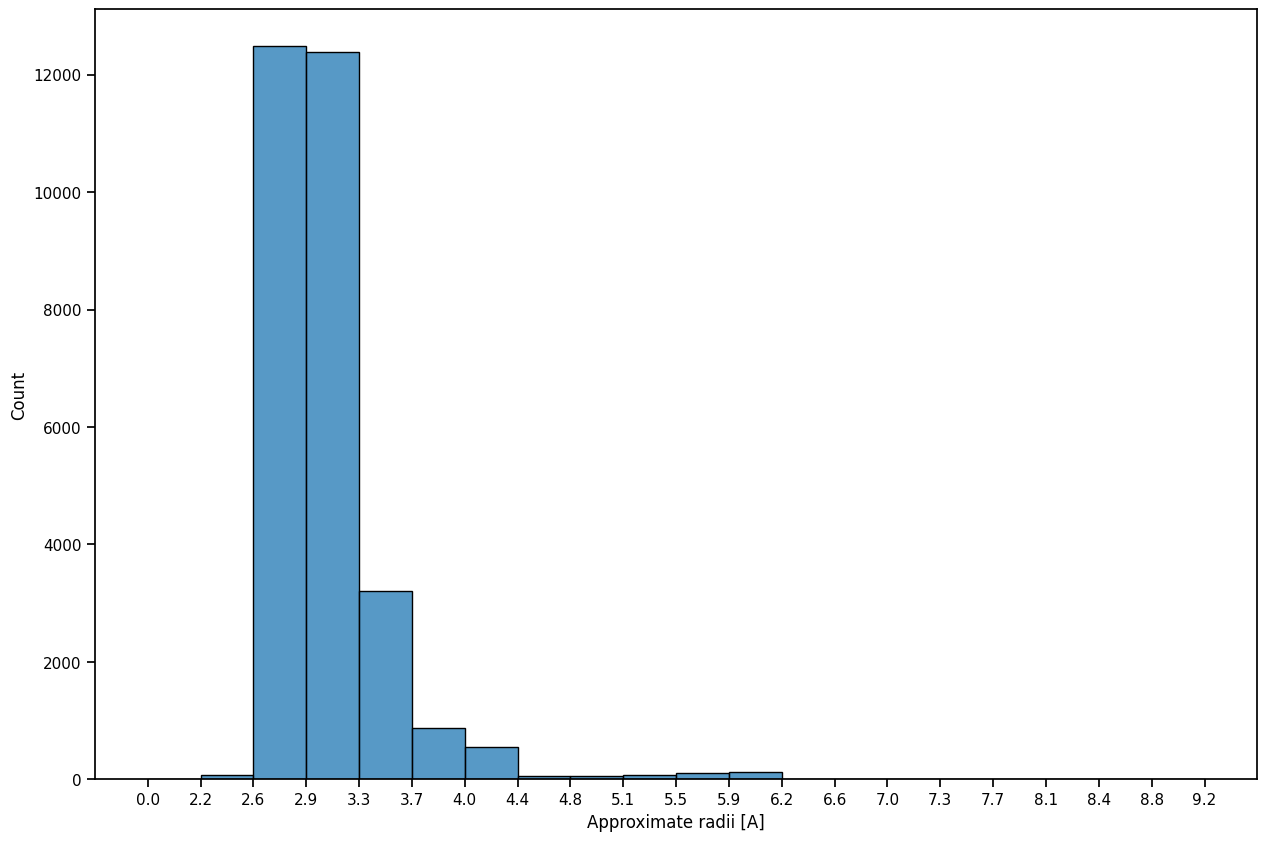

In [23]:
# only radial distribution
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
r_dist = sh_water_traj._assign_trajectory_2_t_grid()
sns.histplot(r_dist, stat="count", bins=np.arange(sh_water_traj.full_grid.get_t_N()+1), ax=ax)
radii = get_between_radii(sh_water_traj.full_grid.get_radii(), include_zero=True)
plt.gca().set_xticks(np.arange(sh_water_traj.full_grid.get_t_N()+1))
plt.gca().set_xticklabels([f"{r:.2}" for r in radii])
plt.gca().set_xlabel("Approximate radii [A]")
plt.show()

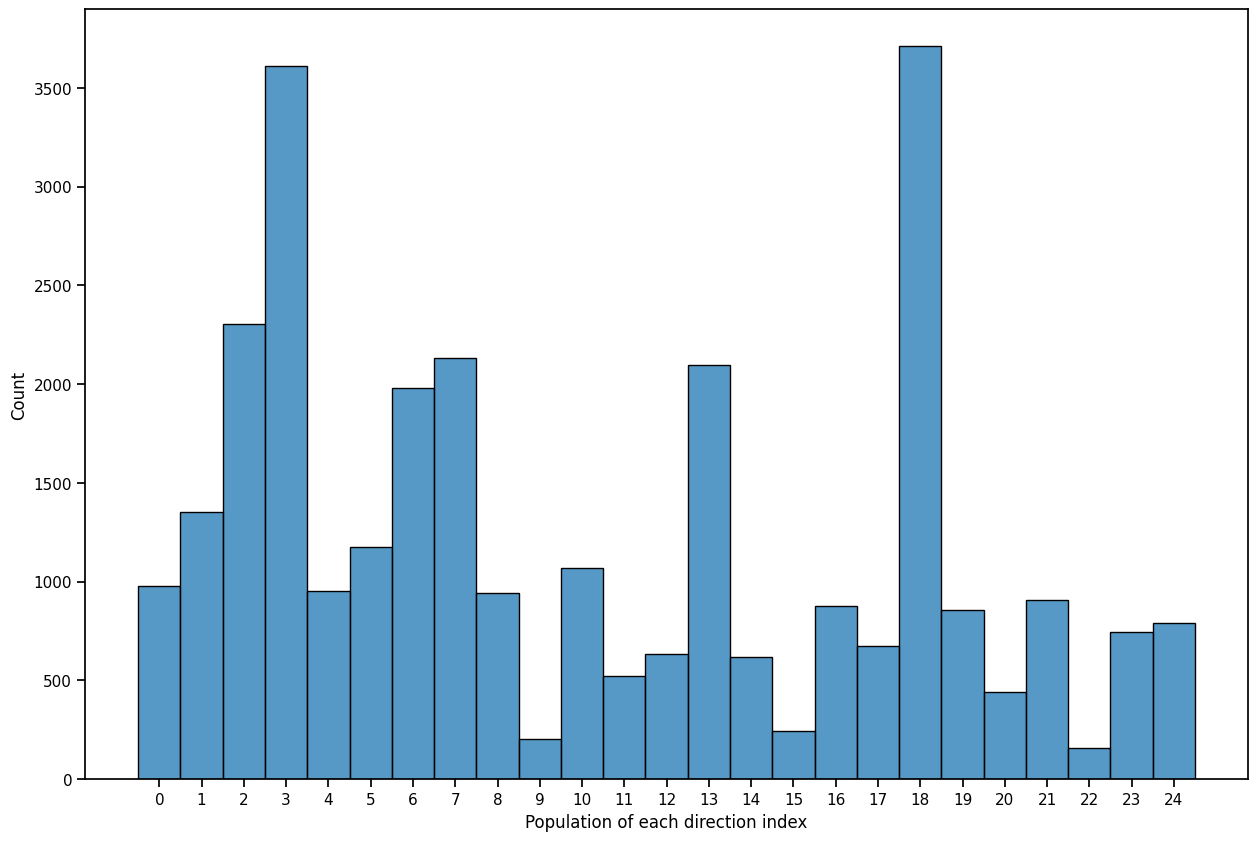

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
o_dist = sh_water_traj._assign_trajectory_2_o_grid()
sns.histplot(o_dist, stat="count", bins=np.arange(sh_water_traj.full_grid.get_o_N()+1), ax=ax)
#radii = get_between_radii(sh_water_traj.full_grid.get_radii(), include_zero=True)
#print(radii, sh_water_traj.full_grid.get_t_N()+1)
plt.gca().set_xticks([0.5 + i for i in np.arange(sh_water_traj.full_grid.get_o_N())])
plt.gca().set_xticklabels(np.arange(sh_water_traj.full_grid.get_o_N()))
plt.gca().set_xlabel("Population of each direction index")
plt.show()

## Orientation space

### Determine internal coordinate system (principal axes)

For each frame and any molecule we need to have a consistent way to determine internal coordinate system. The first step to this are principal axes.

In [26]:
# determine principal axes
second_molecule = "bynum 4:6"

# principal axes of the first frame
pa_zero = pt_universe.select_atoms(second_molecule).principal_axes()
com_zero = pt_universe.select_atoms(second_molecule).center_of_mass()
print(np.round(pa_zero, 3))
print(com_zero+pa_zero[0])

# display principal axes of first frame
vm = ViewManager(pt_universe)
vm.fresh_view()
vm.plot_ith_frame(0)
vm.add_principal_axes(com_zero, pa_zero)
vm.view



[[ 0.     1.     0.   ]
 [-0.599  0.    -0.8  ]
 [-0.8    0.     0.599]]
[-1.70130157  1.          1.0514622 ]


NGLWidget()

In [27]:
vm.fresh_view()

# principal axes change in relation to the stationary coordinate system when the molecule is re-oriented
# but they remain the same in relation to the molecule itself

# using some selected PT frames for demonstration
for i in [20, 63, 284]:
    pt_universe.trajectory[i]
    pa_current = pt_universe.select_atoms(second_molecule).principal_axes()
    com_current = pt_universe.select_atoms(second_molecule).center_of_mass()
    print(np.round(pa_current, 3))

    # display this
    vm.plot_ith_frame(i)
    vm.add_principal_axes(com_current, pa_current)
vm.view

[[-0.     0.     1.   ]
 [ 0.8   -0.599  0.   ]
 [ 0.599  0.8    0.   ]]
[[-0.    -0.     1.   ]
 [ 0.8    0.599  0.   ]
 [-0.599  0.8    0.   ]]
[[ 0.     0.     1.   ]
 [ 0.8   -0.599  0.   ]
 [ 0.599  0.8    0.   ]]


NGLWidget()

... well, almost the same

### Realize that determining principal axes isn't sufficient

What we attempt to do in this cell:

    a) calculate PA of a PT frame as above (where all atoms have been rotated with a rotation matrix)
    b) calculate PA as product of initial PA and a rotation matrix

The results are the same UP TO A SIGN (direction of the vectors)

In [28]:
# LESSION LEARNED: principal axes are axes and NOT vectors - their direction is NOT clearly defined
# see also: https://math.stackexchange.com/questions/145023/rotation-matrix-from-an-inertia-tensor

# python -m molgri.scripts.generate_pt -m1 H2O -m2 H2O -o "1" -b "20" -t "1" --recal
from molgri.space.rotobj import SphereGrid4DFactory
b_selection = SphereGrid4DFactory().create(alg_name="cube4D", N=20).get_grid_as_array()
b_universe = mda.Universe(f"{PATH_OUTPUT_PT}H2O_H2O_0407.gro", f"{PATH_OUTPUT_PT}H2O_H2O_0407.xtc")

vm = ViewManager(b_universe)
vm.fresh_view()
reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}H2O.gro")
reference_principal_axes = reference_structure.atoms.principal_axes()

for i in range(17, 18):
    b_universe.trajectory[i]
    reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}H2O.gro")
    reference_principal_axes = reference_structure.atoms.principal_axes()
    my_R = Rotation(b_selection[i]).as_matrix()
    expected_pa = Rotation(b_selection[i]).apply(reference_principal_axes)
    #expected_pa = (my_R @ reference_principal_axes.T).T

    print("my R @ ref PA\n", np.round(expected_pa.T, 3))

    current_principal_axes = b_universe.select_atoms(second_molecule).principal_axes()
    com_current = b_universe.select_atoms(second_molecule).center_of_mass()
    print("frame PA\n", np.round(current_principal_axes.T, 3))
    vm.plot_ith_frame(i)
    vm.add_principal_axes(com_current, expected_pa)
    vm.add_principal_axes(com_current, current_principal_axes)
vm.view

my R @ ref PA
 [[ 0.    -0.599  0.8  ]
 [ 0.     0.8    0.599]
 [-1.     0.     0.   ]]
frame PA
 [[ 0.     0.599  0.8  ]
 [-0.    -0.8    0.599]
 [ 1.    -0.    -0.   ]]


NGLWidget()

How to solve this: in addition to principal axes, determine positive direction along each PA

Simple idea: take the first atom that isn't perpendicular to that axis and calculate the angle ATOM-COM-PA. The smaller of the angles defines the + direction of this PA.

Some caveats:
- need to take care of round-off errors (save files in high precision, round to the given precision)
- in planar molecules, all atoms are perpendicular to one axis -> solution, use right-handedness of the coordinate axes
- in linear molecules, all atoms are perpendicular to two axes -> still a problem

Given the definitions:

$PA_i$ = initial principal axes as column vectors, $D_i$ = initial direction

$PA_c$ = current principal axes as column vectors, $D_c$ = current direction

$R$ rotation matrix applied on initial to get current

The formula to re-construct the rotation matrix (and from it quaternion) only from the frames of the trajectory and the reference/initial structure is:

($D_c \cdot PA_c$) = $ R @ (D_i \cdot PA_i)$

$R$ = $(\frac{D_c}{D_i} \cdot PA_c) @ (PA_i)^{-1}$

In [29]:
# example: nonplanar molecule (glucose)

def determine_positive_directions(current_universe, second_molecule):
    pas = current_universe.select_atoms(second_molecule).principal_axes()
    com = current_universe.select_atoms(second_molecule).center_of_mass()
    directions = [0, 0, 0]
    for atom_pos in current_universe.select_atoms(second_molecule).positions:
        for i, pa in enumerate(pas):
            # need to round to avoid problems - assigning direction with atoms very close to 0
            cosalpha = np.round(pa.dot(atom_pos-com), 6)
            directions[i] = np.sign(cosalpha)
        if not np.any(np.isclose(directions,0)):
            break
    # TODO: if exactly one unknown use the other two and properties of righthanded systems to get third
    if np.sum(np.isclose(directions,0)) == 1:
        # only these combinations of directions are possible in righthanded coordinate systems
        allowed_righthanded = [[1, 1, 1], [-1, 1, -1], [1, -1, -1], [-1, -1, 1]]
        for ar in allowed_righthanded:
            # exactly two identical (and the third is zero)
            if np.sum(np.isclose(ar, directions)) == 2:
                directions = ar
                break
    # if two (or three - that would just be an atom) unknowns raise an error
    elif np.sum(np.isclose(directions,0)) > 1:
        raise ValueError("All atoms perpendicular to at least one of principal axes, can´t determine direction.")
    return np.array(directions)

# saved PT
my_new_u = mda.Universe(f"{PATH_OUTPUT_PT}glucose_glucose_0025.gro", f"{PATH_OUTPUT_PT}glucose_glucose_0025.trr")
b_selection = SphereGrid4DFactory().create(alg_name="cube4D", N=20).get_grid_as_array()
second_molecule_glu = "bynum 13:24"

# reference structure
reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}glucose.xyz")
second_molecule_ref = "bynum 1:12"
reference_principal_axes = reference_structure.atoms.principal_axes().T
inverse_pa = np.linalg.inv(reference_principal_axes)
reference_direction = determine_positive_directions(reference_structure, second_molecule_ref)

# frame 0: q3 in direction C-O, frame 1: q3 in direction O
for i in range(20):
    my_new_u.trajectory[i]
    com_current = my_new_u.select_atoms(second_molecule_glu).center_of_mass()
    current_principal_axes = my_new_u.select_atoms(second_molecule_glu).principal_axes().T
    current_directions = determine_positive_directions(my_new_u, second_molecule_glu)
    direction = current_directions / reference_direction
    produkt = np.multiply(current_principal_axes, np.tile(direction, (3, 1))) @ inverse_pa
    calc_quat = np.round(Rotation.from_matrix(produkt).as_quat(), 6) 
    if not q_in_upper_sphere(calc_quat):
        calc_quat = -calc_quat
    print(current_directions)
    print(np.allclose(b_selection[i], calc_quat, atol=1e-5, rtol=1e-5), b_selection[i], calc_quat)

[-1.  1. -1.]
True [ 0.5 -0.5 -0.5  0.5] [ 0.5 -0.5 -0.5  0.5]
[1. 1. 1.]
True [ 0.5 -0.5  0.5 -0.5] [ 0.5 -0.5  0.5 -0.5]
[ 1. -1. -1.]
True [0.5 0.5 0.5 0.5] [0.5 0.5 0.5 0.5]
[1. 1. 1.]
True [ 0.5  0.5 -0.5  0.5] [ 0.5  0.5 -0.5  0.5]
[-1. -1.  1.]
True [ 0.5 -0.5  0.5  0.5] [ 0.5 -0.5  0.5  0.5]
[ 1. -1. -1.]
True [ 0.5  0.5  0.5 -0.5] [ 0.5  0.5  0.5 -0.5]
[-1. -1.  1.]
True [ 0.5  0.5 -0.5 -0.5] [ 0.5  0.5 -0.5 -0.5]
[-1.  1. -1.]
True [ 0.5 -0.5 -0.5 -0.5] [ 0.5 -0.5 -0.5 -0.5]
[ 1. -1. -1.]
True [ 0.57735027 -0.57735027  0.          0.57735027] [ 0.57735 -0.57735  0.       0.57735]
[1. 1. 1.]
True [0.70710678 0.70710678 0.         0.        ] [ 0.707107  0.707107  0.       -0.      ]
[-1. -1.  1.]
True [0.         0.         0.70710678 0.70710678] [-0.        0.        0.707107  0.707107]
[1. 1. 1.]
True [0.70710678 0.         0.70710678 0.        ] [0.707107 0.       0.707107 0.      ]
[1. 1. 1.]
True [ 0.          0.57735027  0.57735027 -0.57735027] [ 0.       0.57735  0.5773

In [30]:
# example: planar molecule (water)
#python -m molgri.scripts.generate_pt -m1 H2O_a -m2 H2O_a -o "1" -b "20" -t "0.3" --recal --extension_structure gro --extension_trajectory trr


# saved PT
my_new_u = mda.Universe(f"{PATH_OUTPUT_PT}H2O_a_H2O_a_0000.gro", f"{PATH_OUTPUT_PT}H2O_a_H2O_a_0000.trr")
b_selection = SphereGrid4DFactory().create(alg_name="cube4D", N=20).get_grid_as_array()
second_molecule_glu = "bynum 4:6"

# reference structure
reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}H2O_a.gro")
second_molecule_ref = "bynum 1:3"
reference_principal_axes = reference_structure.atoms.principal_axes().T
inverse_pa = np.linalg.inv(reference_principal_axes)
reference_direction = determine_positive_directions(reference_structure, second_molecule_ref)

# frame 0: q3 in direction C-O, frame 1: q3 in direction O
for i in range(20):
    my_new_u.trajectory[i]
    com_current = my_new_u.select_atoms(second_molecule_glu).center_of_mass()
    current_principal_axes = my_new_u.select_atoms(second_molecule_glu).principal_axes().T
    current_directions = determine_positive_directions(my_new_u, second_molecule_glu)
    direction = current_directions * reference_direction
    produkt = np.multiply(current_principal_axes, np.tile(direction, (3, 1))) @ inverse_pa
    calc_quat = np.round(Rotation.from_matrix(produkt).as_quat(), 6) 
    if not q_in_upper_sphere(calc_quat):
        calc_quat = -calc_quat
    print(np.allclose(b_selection[i], calc_quat, atol=1e-6, rtol=1e-5), b_selection[i], calc_quat)

True [ 0.5 -0.5 -0.5  0.5] [ 0.5 -0.5 -0.5  0.5]
True [ 0.5 -0.5  0.5 -0.5] [ 0.5 -0.5  0.5 -0.5]
True [0.5 0.5 0.5 0.5] [0.5 0.5 0.5 0.5]
True [ 0.5  0.5 -0.5  0.5] [ 0.5  0.5 -0.5  0.5]
True [ 0.5 -0.5  0.5  0.5] [ 0.5 -0.5  0.5  0.5]
True [ 0.5  0.5  0.5 -0.5] [ 0.5  0.5  0.5 -0.5]
True [ 0.5  0.5 -0.5 -0.5] [ 0.5  0.5 -0.5 -0.5]
True [ 0.5 -0.5 -0.5 -0.5] [ 0.5 -0.5 -0.5 -0.5]
True [ 0.57735027 -0.57735027  0.          0.57735027] [ 0.57735 -0.57735  0.       0.57735]
True [0.70710678 0.70710678 0.         0.        ] [ 0.707107  0.707107 -0.       -0.      ]
True [0.         0.         0.70710678 0.70710678] [-0.       -0.        0.707107  0.707107]
True [0.70710678 0.         0.70710678 0.        ] [ 0.707107 -0.        0.707107 -0.      ]
True [ 0.          0.57735027  0.57735027 -0.57735027] [ 0.       0.57735  0.57735 -0.57735]
True [ 0.70710678  0.          0.         -0.70710678] [ 0.707107 -0.       -0.       -0.707107]
True [ 0.57735027  0.          0.57735027 -0.57735027]

In summary:
- save and use (pseudo)trajectories in high-precision TRR format
- determine principal axes of the reference structure and every frame of the PT
- determine direction of each PA from the coordinates of the first atom that isn't perpendicular to it
- if a molecule is planar, you can still determine directions from right-handedness of PAs
- it doesn't make much sense to compare to PAs alone, since you'd need to make sure that the calculation of direction is defined the same way in both cases

TODO:
- need a better symmetry handling for linear molecules

### Determine quaternion index

1) determine the quaternion that rotates the reference structure to the current structure (see above)
2) calculate distance (quaternion metric) to all quaternion grid points and select the closest one

In [31]:
# example: PT
# python -m molgri.scripts.generate_pt -m1 H2O -m2 H2O -o 5 -t "[0.3, 0.6]" -b 25 --extension_traj trr --recal
sh = SimulationHistogram("H2O_H2O_0529", "H2O", is_pt=True, full_grid=None,
                                 second_molecule_selection="bynum 4:6", use_saved=False)
quat_assignents = sh.get_quaternion_assignments()
print(quat_assignents)

# assert assignments exactly 0, 1, 2 ...N_b, 0, 1, 2 ... N_b, 0, 1, ... 
assert np.all(quat_assignents == sh.full_grid.get_quaternion_index())

# now let's view this
vm = ViewManager(sh.trajectory_universe)
# plot a selection (because too many) that are all assigned to grid point 1
assigned_to_cell = np.where(quat_assignents == 1)[0]
# show in VMD for a better view
print(list(assigned_to_cell))
vm.plot_frames_overlapping(np.random.choice(assigned_to_cell, 30))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18
 19 20 21 22 23 24  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
 17 18 19 20 21 22 23 24  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
 16 17 18 19 20 21 22 23 24  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 15 16 17 18 19 20 21 22 23 24]
[1, 26, 51, 76, 101, 126, 151, 176, 201, 226]


NGLWidget()

In [32]:
# test with a real trajectory: see how long it takes
H2O_full_grid = FullGrid(b_grid_name="40", o_grid_name="42", t_grid_name="linspace(0.2, 0.9, 20)",
                        use_saved=False)

# H2O_H2O_0095_25000
sh = SimulationHistogram("H2O_H2O_0095_30000", "H2O", is_pt=False,
                             full_grid=H2O_full_grid,
                             second_molecule_selection="bynum 4:6",
                         use_saved=False)

print(f"Assigning {len(sh.trajectory_universe.trajectory)} frames to {sh.full_grid.get_b_N()} quaternions")

quaternion_assignments = sh.get_quaternion_assignments()

Assigning 30001 frames to 40 quaternions


[21 21 21 ... 20 20 20]
Most popular assignments are [25 21 33] with population [1567 1821 2189]


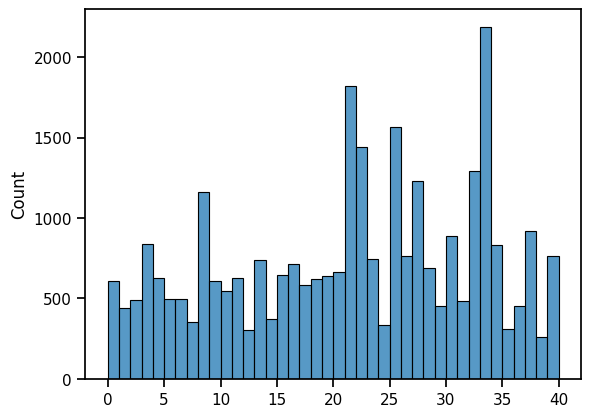

In [33]:
# make a histogram of most populated quaternions
print(quaternion_assignments)
sns.histplot(quaternion_assignments, stat="count", bins=np.arange(1+sh.full_grid.get_b_N()))

popular, counts = np.unique(quaternion_assignments, return_counts=True)
max_counts = k_argmax_in_array(counts, 3)
print(f"Most popular assignments are {popular[max_counts]} with population {counts[max_counts]}")

In [36]:
# plot some frames of a real trajectory that belong to the same quaternion grid point
vm = ViewManager(sh.trajectory_universe)
# plot a selection (because too many) that are all assigned to grid point
assigned_to_37 = np.where(quaternion_assignments == 33)[0]
# show in VMD for a better view
print(list(np.random.choice(assigned_to_37, 100)))


print("Reference", sh.full_grid.b_rotations.get_grid_as_array()[33])
det_quats = sh._determine_quaternions()

subset = np.random.choice(assigned_to_37, 30)
for my_frame in subset:
    print(det_quats[my_frame])

vm.plot_frames_overlapping(subset)

[28276, 13827, 27464, 4886, 27495, 29149, 26764, 29068, 23516, 11083, 21696, 26072, 29015, 27809, 26507, 11056, 8319, 21710, 26933, 28302, 8124, 13783, 27157, 21361, 29156, 27472, 19200, 20180, 21132, 26930, 28096, 3216, 21140, 28264, 28273, 2831, 19617, 21694, 3232, 22921, 22290, 10212, 26950, 21944, 13846, 5795, 21150, 9212, 29066, 29142, 13821, 26996, 10979, 13845, 28088, 20260, 27401, 8327, 26519, 27478, 24729, 27467, 26915, 27506, 19529, 20158, 5197, 21244, 29042, 27847, 22297, 28270, 26499, 25859, 20256, 21211, 5588, 25849, 21136, 26088, 3244, 27472, 13834, 20241, 26019, 21936, 25992, 19528, 3234, 27477, 9213, 25846, 19192, 28067, 21914, 29028, 22491, 27005, 21139, 26997]
Reference [0. 1. 0. 0.]
[-0.090371  0.907147 -0.277277  0.303372]
[ 0.232604  0.971948 -0.025152 -0.024099]
[-0.190345  0.914187 -0.088067 -0.346806]
[ 0.295813  0.884066 -0.219297 -0.287803]
[-0.140087  0.984911 -0.036586 -0.094806]
[-0.172521  0.983154  0.007748  0.059866]
[ 0.33608   0.900674 -0.074899 -0.265

NGLWidget()

In [35]:
# plot some frames of a real trajectory that belong to the same quaternion grid point
vm = ViewManager(sh.trajectory_universe)
# plot a selection (because too many) that are all assigned to grid point 21
assigned_to_14 = np.where(quaternion_assignments == 14)[0]
# show in VMD for a better view
print(list(np.random.choice(assigned_to_14, 100)))
vm.plot_frames_overlapping(np.random.choice(assigned_to_14, 30))

[24843, 15006, 15921, 11786, 2626, 17606, 24365, 14989, 4122, 12736, 25238, 4658, 2633, 14973, 11788, 11789, 4123, 2626, 15011, 18161, 25237, 11789, 10021, 14223, 17607, 18159, 11790, 12739, 4143, 10051, 16470, 15008, 18162, 10040, 18151, 10011, 14971, 8503, 9001, 18170, 24385, 10026, 18481, 18169, 10037, 14220, 8506, 8503, 18465, 18463, 10047, 10017, 10026, 14221, 24368, 8516, 18155, 24375, 10038, 2626, 12738, 18399, 24392, 18482, 4654, 15009, 14985, 17604, 4136, 4656, 14996, 12743, 24400, 14967, 14974, 10041, 24403, 18168, 4136, 24384, 15012, 14986, 10038, 10014, 9005, 8515, 18153, 17605, 4650, 24392, 9006, 8516, 15000, 18487, 10032, 15013, 15931, 4588, 18481, 8997]


NGLWidget()

In [37]:
# What happens for linear molecules? HF assigned to 8 quaternions


HF_HF_SH  = SimulationHistogram("ts_symmetric_ts_symmetric_0000", "ts_symmetric", is_pt=True,
                             full_grid=None,
                             second_molecule_selection="bynum 4:6")

print(f"Assigning PT frames of a linear molecule.")

hf_ass = HF_HF_SH.get_quaternion_assignments()

Assigning PT frames of a linear molecule.


ValueError: All atoms perpendicular to at least one of principal axes, can´t determine direction.

## Full conversion 3N coordinates <-> 7D gridpoint

Full index = position_index * num_quaternions + quaternion_index

In [38]:
full_assignments = sh.get_full_assignments()

Most popular assignments are [6501 4825 6593 4830 4905 6513 4808 4822 4827 4833] with population [169 173 175 178 189 337 204 213 278 270]


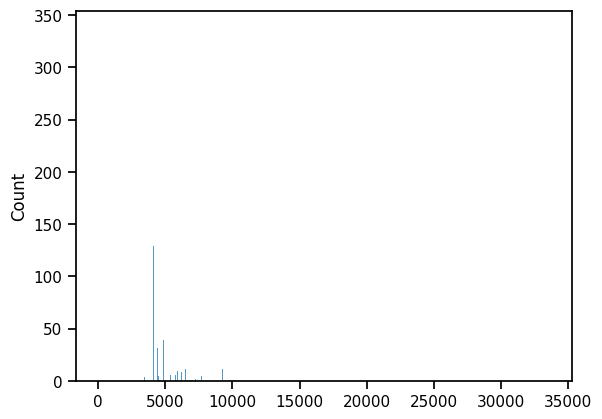

In [39]:
# make a histogram of most populated full grid cells
sns.histplot(full_assignments, stat="count", bins=np.arange(len(H2O_full_grid)+1))

popular, counts = np.unique(full_assignments, return_counts=True)
max_counts = k_argmax_in_array(counts, 10)
print(f"Most popular assignments are {popular[max_counts]} with population {counts[max_counts]}")

In [40]:
vm = ViewManager(sh.trajectory_universe)
# plot a selection (because too many) that are all assigned to same grid point
assigned_to_cell = np.where(full_assignments == 4822)[0]
# show in VMD for a better view
print(list(assigned_to_cell))
vm.plot_frames_overlapping(np.random.choice(assigned_to_cell, 30))

[2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 5423, 5424, 5425, 5434, 5435, 5436, 5437, 5438, 5439, 5440, 5441, 5442, 5443, 5444, 5445, 5446, 5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5840, 5841, 16550, 16551, 16552, 16553, 16554, 16555, 16556, 16557, 16558, 16559, 16560, 16561, 16578, 16579, 16580, 16581, 17731, 17732, 17733, 17734, 17735, 17736, 17737, 17738, 17739, 17740, 17741, 17742, 17743, 17744, 17745, 17746, 17747, 17748, 17749, 17750, 17751, 17752, 17753, 17754, 17755, 17756, 17757, 17758, 17759, 17760, 17761, 17762, 17763, 17764, 17765, 17766, 18677, 18678, 18679, 18680, 18681, 18712, 18713, 18714, 18951, 18952, 18953, 18954, 18955, 18956, 18987, 18988, 18989, 18990, 18991, 19100, 19101, 19102, 19103, 19104, 19105, 19106, 19107, 19281, 19282, 19283, 19579, 19580, 20512, 20513, 20514, 20515, 20516, 20517, 20518, 20519, 20520, 20521, 20522, 20523, 20524, 20533, 20534, 

NGLWidget()

In [50]:
vm = ViewManager(sh.trajectory_universe)
# plot a selection (because too many) that are all assigned to same grid point
assigned_to_cell = np.where(full_assignments == 19621)[0]

# show in VMD for a better view
print(list(assigned_to_cell))
vm.plot_frames_overlapping(np.random.choice(assigned_to_cell, 30))



[16581 16861 17381 17821 18181 18301 18741 19181 19501 19621] [30 43  3  5 20 30 36 21 39 29]
[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]


NGLWidget()

## MSM

In [77]:
water_sh = SimulationHistogram("H2O_H2O_0095_30000", "H2O", is_pt=False,
                             full_grid=FullGrid(b_grid_name="160", o_grid_name="42",
                                                t_grid_name="linspace(0.2, 1, 20)"),
                             second_molecule_selection="bynum 4:6", use_saved=True)
#water_MSM = MSM(water_sh, tau_array=np.array([100, 150, 200, 300, 500, 700, 1000, 1500, 2000]))
#water_MSM.get_transitions_matrix()
#my_eval, my_evec = water_MSM.get_eigenval_eigenvec(8, which="LR")
#print(my_eval)

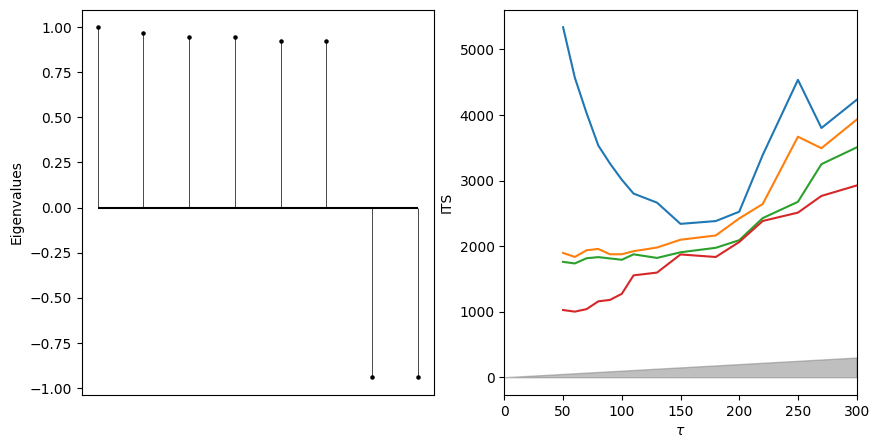

In [79]:
tp = TransitionPlot(water_sh, tau_array=np.array([50, 60, 70, 80, 90, 100, 110, 130, 150, 180, 200, 220,
                                                250, 270, 300]))
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))
tp.plot_eigenvalues(num_eigenv=5, index_tau=5, save=False, fig=fig, ax=ax[0])
tp.plot_its(5, as_line=False, save=False, fig=fig, ax=ax[1])
plt.show()

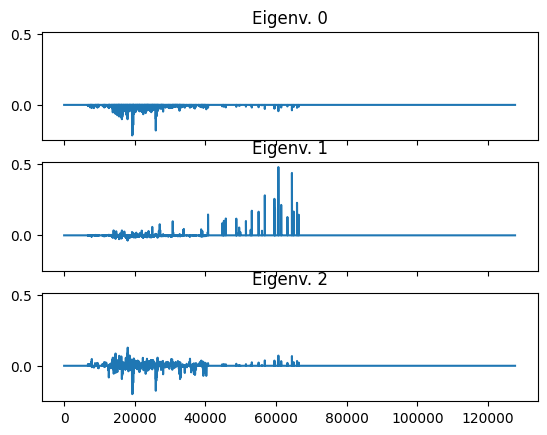

In [80]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i], index_tau=5)
plt.show()

In [83]:
vm = ViewManager(water_sh.trajectory_universe)
vm.fresh_view()
water_sh.use_saved = True
magnitudes = water_sh.get_magnitude_ith_eigenvector(2)
vm.set_color_magnitude(magnitudes, )
print(magnitudes.shape)

# 
num_extremes = 2
most_positive = np.argmax(magnitudes)
most_negative = np.argmin(magnitudes)
print(f"2nd position eigenvector has most negative cell {most_negative} and most positive cell {most_positive}.")
# now assign these to trajectory frames
assigned_frames = []
colors = []
for one_argmax in [most_negative, most_positive]:
    all_assigned = water_sh.get_indices_same_cell(one_argmax)
    assigned_frames.extend(all_assigned)
    colors.extend([vm.current_magnitudes[one_argmax]])
vm.current_magnitudes = None
print(assigned_frames)

vm.plot_frames_overlapping(np.random.choice(assigned_frames, 30))
vm.view

(127680,)
2nd position eigenvector has most negative cell 18003 and most positive cell 35628.
[1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 4229, 4230, 4231, 4232, 4233, 4234, 6401, 6402, 6403, 6404, 6405, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6898, 6899, 6900, 6901, 6902, 7042, 7043, 7044, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 11984, 11985, 12061, 12062, 12063, 12064, 12065, 12066, 12067, 12068, 12069, 12070, 12071, 12072, 12073, 12074, 12075, 12076, 12077, 12078, 12079, 12080, 12081, 12082, 12083, 9661, 9662, 9663, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9671, 9672, 9673, 9674, 9675, 9676, 9677, 9678, 9679]


NGLWidget()

In [31]:
# -> direction: INPUT start coordinates (3N), 7D gridpoint; OUTPUT end coordinates (3N)
# <- direction: INPUT end coordinates (3N), start coordinates (3N); OUTPUT 7D gridpoint